In [2]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi

# to see plots inline
%matplotlib inline

In [3]:
# read json file
filename = 'transaction-data-adhoc-analysis.json'
df = pd.read_json(filename)

# FOR REFERENCE: dump file here

In [4]:
# FOR REFERENCE: dump with items, value, and date
df = df[['name','transaction_items','transaction_value','transaction_date']]

# FOR REFERENCE: dump file here

In [5]:
## PART 1: CLEANING/FILTERING ---------------------------------------------------------------------------------------------
# checking items in transactions
transactions = list(df['transaction_items'])

In [6]:
# splitting the transactions with more than one item variety
transaction_split = [transactions[i].split(';') for i in range(len(transactions))]
df_items = pd.DataFrame({'Raw Items':transaction_split})
df_items

# using explode
df1 = df_items.explode('Raw Items')

# dump here (should contain raw items)

In [7]:
# getting the item only
item_list = list(df1['Raw Items'])
item_only = [item_list[i][item_list[i].find(',')+1:-5] for i in range(len(item_list))]
df1['Items'] = item_only
df1['Items'].mask(df1['Items'] == 'Nutrional Milk', 'Nutritional Milk' , inplace=True )

# dump here (should contain raw items & items only)

In [8]:
# adding month
dates = df[['transaction_date']].squeeze()
dates = pd.to_datetime(dates)
month = dates.dt.month_name()
df1['Month of Transaction'] = month

# dump here: df1[['Items','Month of Transaction']]

In [9]:
# adding the quantity
quantity = [int(item_list[i][item_list[i].find('(')+2:-1]) for i in range(len(item_list))]
df1['Quantity'] = quantity

# dump here: df1[['Items','Quantity','Month of Transaction']]

In [10]:
# FOR REFERENCE: dump transaction_value
raw_value = df['transaction_value']
df1['Total Transaction Value']=raw_value

## df1[['Items','Quantity','Total Transaction Value','Month of Transaction']]

In [11]:
# getting price per item
chicharon_condition = df1.loc[:,'Items']=='Beef Chicharon'
milk_condition = df1.loc[:,'Items']=='Nutritional Milk'
beans_condition = df1.loc[:,'Items']=='Orange Beans'
vits_condition = df1.loc[:,'Items']=='Gummy Vitamins'
veggies_condition = df1.loc[:,'Items']=='Yummy Vegetables'
worms_condition = df1.loc[:,'Items']=='Gummy Worms'
kimchi_condition = df1.loc[:,'Items']=='Kimchi and Seaweed'

price_list = {'Beef Chicharon':list(df1.loc[chicharon_condition,:].min(numeric_only=True))[1],
              'Nutritional Milk':list(df1.loc[milk_condition,:].min(numeric_only=True))[1],
              'Orange Beans':list(df1.loc[beans_condition,:].min(numeric_only=True))[1],
              'Gummy Vitamins':list(df1.loc[vits_condition,:].min(numeric_only=True))[1],
              'Yummy Vegetables':list(df1.loc[veggies_condition,:].min(numeric_only=True))[1],
              'Gummy Worms':list(df1.loc[worms_condition,:].min(numeric_only=True))[1],
              'Kimchi and Seaweed':list(df1.loc[kimchi_condition,:].min(numeric_only=True))[1]}

In [12]:
# adding the price per item

def price_per_item(x):
    price_list = {'Beef Chicharon': 1299,
                  'Nutritional Milk': 1990,
                  'Orange Beans': 199,
                  'Gummy Vitamins': 1500,
                  'Yummy Vegetables': 500,
                  'Gummy Worms': 150,
                  'Kimchi and Seaweed': 799}
    return price_list[x]

df1['Price per Item']=df1['Items'].apply(price_per_item)

# dump here: df1[['Items','Price per Item','Quantity','Month of Transaction']]

In [13]:
# add total sale value by multiplying price per item and quanitity
df1['Total Sale Value']=df1['Price per Item']*df1['Quantity']

# dump
df1[['Items','Price per Item','Quantity','Total Sale Value','Month of Transaction']]

,Items,Price per Item,Quantity,Total Sale Value,Month of Transaction
0,Beef Chicharon,1299,4,5196,January
1,Beef Chicharon,1299,3,3897,January
1,Nutritional Milk,1990,4,7960,January
1,Orange Beans,199,1,199,January
2,Gummy Vitamins,1500,3,4500,January
...,...,...,...,...,...
83034,Nutritional Milk,1990,2,3980,June
83034,Gummy Worms,150,2,300,June
83035,Nutritional Milk,1990,1,1990,June
83035,Gummy Worms,150,3,450,June


In [14]:
## PART 2: TABLE FOR COUNT OF EACH ITEM SOLD PER MONTH ------------------------------------------------------------------
# grouby items, month, and quantity
monthly_quantity = df1.groupby(['Items','Month of Transaction'],as_index=False)['Quantity'].sum().pivot('Items','Month of Transaction').fillna(0)

# put the months in the correct order
from calendar import month_name
month_dtype = pd.CategoricalDtype(categories=list(month_name), ordered=True)
monthly_quantity.columns = [monthly_quantity.columns.get_level_values(0),monthly_quantity.columns.get_level_values(1).astype(month_dtype)]
monthly_quantity = monthly_quantity.sort_index(axis=1, level=[1, 0])

monthly_quantity

Quantity                                     
Month of Transaction  January February  March  April    May   June
Items                                                             
Beef Chicharon           9665    10001   9816   9890  10028   9902
Gummy Vitamins           9681     9980  10145   9842   9948   9980
Gummy Worms              9559     9996   9986  10043   9801   9934
Kimchi and Seaweed       9676     9949   9967   9921   9773  10104
Nutritional Milk         9727     9691   9876   9786   9881   9767
Orange Beans             9774    10037   9611   9914   9964  10106
Yummy Vegetables         9959    10256   9896   9861   9735   9722

In [15]:
## PART 3: TABLE FOR TOTAL SALE VALUE OF EACH ITEM PER MONTH ------------------------------------------------------------
# grouby items, month, and quantity
monthly_value = df1.groupby(['Items','Month of Transaction'],as_index=False)['Total Sale Value'].sum().pivot('Items','Month of Transaction').fillna(0)

# put the months in the correct order
monthly_value.columns = [monthly_value.columns.get_level_values(0),monthly_value.columns.get_level_values(1).astype(month_dtype)]
monthly_value = monthly_value.sort_index(axis=1, level=[1, 0])

monthly_value

Total Sale Value                                          \
Month of Transaction          January  February     March     April       May   
Items                                                                           
Beef Chicharon               12554835  12991299  12750984  12847110  13026372   
Gummy Vitamins               14521500  14970000  15217500  14763000  14922000   
Gummy Worms                   1433850   1499400   1497900   1506450   1470150   
Kimchi and Seaweed            7731124   7949251   7963633   7926879   7808627   
Nutritional Milk             19356730  19285090  19653240  19474140  19663190   
Orange Beans                  1945026   1997363   1912589   1972886   1982836   
Yummy Vegetables              4979500   5128000   4948000   4930500   4867500   

                                
Month of Transaction      June  
Items                           
Beef Chicharon        12862698  
Gummy Vitamins        14970000  
Gummy Worms            1490100  
Kimchi and Seaweed     8073096  
Nutritional Milk      19436330  
Orange Beans           2011094  
Yummy Vegetables       4861000

In [16]:
## PART 4: CONTRCUCTING SCRATCH TABLE FOR CUSTOMER TABLE ------------------------------------------------------------------
# FOR REFERENCE: dump customer name and month of transaction
df1['Customer Name']=df['name']

# dump here: df1[['Customer Name','Month of Transaction']]

In [17]:
# groupby customer name
customer_transactions = df1.groupby('Customer Name')['Month of Transaction'].apply(' '.join).reset_index()

# checking mothly customer transactions
customer_transactions['January'] = customer_transactions['Month of Transaction'].str.contains('January')
customer_transactions['February'] = customer_transactions['Month of Transaction'].str.contains('February')
customer_transactions['March'] = customer_transactions['Month of Transaction'].str.contains('March')
customer_transactions['April'] = customer_transactions['Month of Transaction'].str.contains('April')
customer_transactions['May'] = customer_transactions['Month of Transaction'].str.contains('May')
customer_transactions['June'] =  customer_transactions['Month of Transaction'].str.contains('June')

customer_transactions[['Customer Name','January','February','March','April','May','June']]

,Customer Name,January,February,March,April,May,June
0,Aaron Beasley,False,False,False,True,True,True
1,Aaron Brewer,True,True,True,True,False,True
2,Aaron Brown,False,False,True,True,True,True
3,Aaron Coffey,True,True,True,True,True,False
4,Aaron Davis,True,True,False,True,True,True
...,...,...,...,...,...,...,...
8482,Zachary Valentine,True,True,True,True,True,True
8483,Zachary Ware,True,True,True,True,True,True
8484,Zachary Williams,True,True,True,True,False,False
8485,Zachary Wilson,False,False,False,True,True,True


In [18]:
# add to the scratch table
# REPEATERS: true in the current and previous month

choices = ['Repeaters','']
fr_condition = [(customer_transactions['January'].eq(True)) & 
                (customer_transactions['January'].eq(customer_transactions['February'])),
                customer_transactions['January'].eq(False)]
marr_condition = [(customer_transactions['February'].eq(True)) & 
                  (customer_transactions['February'].eq(customer_transactions['March'])),
                  customer_transactions['February'].eq(False)]
ar_condition = [(customer_transactions['March'].eq(True)) & 
                (customer_transactions['March'].eq(customer_transactions['April'])),
                customer_transactions['March'].eq(False)]
mayr_condition = [(customer_transactions['April'].eq(True)) & 
                  (customer_transactions['April'].eq(customer_transactions['May'])),
                  customer_transactions['April'].eq(False)]
jr_condition = [(customer_transactions['May'].eq(True)) & 
                (customer_transactions['May'].eq(customer_transactions['June'])),
                customer_transactions['May'].eq(False)]

customer_transactions['r_january'] = ''
customer_transactions['r_february'] = np.select(fr_condition, choices, default='')
customer_transactions['r_march'] = np.select(marr_condition, choices, default='')
customer_transactions['r_april'] = np.select(ar_condition, choices, default='')
customer_transactions['r_may'] = np.select(mayr_condition, choices, default='')
customer_transactions['r_june'] = np.select(jr_condition, choices, default='')

# dump here: customer_transactions[['Customer Name','January','February','March','April','May','June','r_january','r_february','r_march','r_april','r_may','r_june']]

In [19]:
# checking repeaters per month using count
feb_cond = customer_transactions.loc[:,'r_february']=='Repeaters'
mar_cond = customer_transactions.loc[:,'r_march']=='Repeaters'
apr_cond = customer_transactions.loc[:,'r_april']=='Repeaters'
may_cond = customer_transactions.loc[:,'r_may']=='Repeaters'
jun_cond = customer_transactions.loc[:,'r_june']=='Repeaters'

repeaters = {'January':0,'February':list(customer_transactions.loc[feb_cond,:].count())[0],
             'March':list(customer_transactions.loc[mar_cond,:].count())[0],
             'April':list(customer_transactions.loc[apr_cond,:].count())[0],
             'May':list(customer_transactions.loc[may_cond,:].count())[0],
             'June':list(customer_transactions.loc[jun_cond,:].count())[0]}

In [20]:
# INACTIVE: false for the current month and true in at least one of the past months
choices2 = ['Inactive','']
fi_condition = [(customer_transactions['January'].eq(True)) & 
                (customer_transactions['February'].eq(False)),
                customer_transactions['January'].eq(False)]
mari_condition = [(customer_transactions['March'].eq(False)) & 
                  (customer_transactions[['January','February']].any(axis='columns')),
                customer_transactions['March'].eq(True)]
ai_condition = [(customer_transactions['April'].eq(False)) & 
                  (customer_transactions[['January','February','March']].any(axis='columns')),
                customer_transactions['April'].eq(True)]
mayi_condition = [(customer_transactions['May'].eq(False)) & 
                  (customer_transactions[['January','February','March','April']].any(axis='columns')),
                customer_transactions['May'].eq(True)]
ji_condition = [(customer_transactions['June'].eq(False)) & 
                  (customer_transactions[['January','February','March','April','May']].any(axis='columns')),
                customer_transactions['June'].eq(True)]

customer_transactions['i_january'] = ''
customer_transactions['i_february'] = np.select(fi_condition, choices2, default='')
customer_transactions['i_march'] = np.select(mari_condition, choices2, default='')
customer_transactions['i_april'] = np.select(ai_condition, choices2, default='')
customer_transactions['i_may'] = np.select(mayi_condition, choices2, default='')
customer_transactions['i_june'] = np.select(ji_condition, choices2, default='')


# dump here: customer_transactions[['Customer Name','January','February','March','April','May','June','i_january','i_february','i_march','i_april','i_may','i_june']]

In [21]:
# checking inactive per month using count
feb_cond2 = customer_transactions.loc[:,'i_february']=='Inactive'
mar_cond2 = customer_transactions.loc[:,'i_march']=='Inactive'
apr_cond2 = customer_transactions.loc[:,'i_april']=='Inactive'
may_cond2 = customer_transactions.loc[:,'i_may']=='Inactive'
jun_cond2 = customer_transactions.loc[:,'i_june']=='Inactive'

inactive = {'January':0,'February':list(customer_transactions.loc[feb_cond2,:].count())[0],
             'March':list(customer_transactions.loc[mar_cond2,:].count())[0],
             'April':list(customer_transactions.loc[apr_cond2,:].count())[0],
             'May':list(customer_transactions.loc[may_cond2,:].count())[0],
             'June':list(customer_transactions.loc[jun_cond2,:].count())[0]}

In [65]:
# ENGAGED: true for the current and previous months
choices3 = ['Engaged','']
jane_condition = [customer_transactions['January'].eq(True),
                   customer_transactions['January'].eq(False)]
fe_condition = [customer_transactions[['January','February']].all(axis='columns'),
                customer_transactions['January'].eq(False)]
mare_condition = [customer_transactions[['January','February','March']].all(axis='columns'),
                customer_transactions['January'].eq(False)]
ae_condition = [customer_transactions[['January','February','March','April']].all(axis='columns'),
                customer_transactions['January'].eq(False)]
maye_condition = [customer_transactions[['January','February','March','April','May']].all(axis='columns'),
                customer_transactions['January'].eq(False)]
je_condition = [customer_transactions[['January','February','March','April','May','June']].all(axis='columns'),
                customer_transactions['January'].eq(False)]

customer_transactions['e_january'] = np.select(jane_condition, choices3, default='')
customer_transactions['e_february'] = np.select(fe_condition, choices3, default='')
customer_transactions['e_march'] = np.select(mare_condition, choices3, default='')
customer_transactions['e_april'] = np.select(ae_condition, choices3, default='')
customer_transactions['e_may'] = np.select(maye_condition, choices3, default='')
customer_transactions['e_june'] = np.select(je_condition, choices3, default='')

# dump here: customer_transactions[['Customer Name','January','February','March','April','May','June','e_january','e_february','e_march','e_april','e_may','e_june']]

In [66]:
# checking engaged per month using count
jan_cond3 = customer_transactions.loc[:,'e_january']=='Engaged'
feb_cond3 = customer_transactions.loc[:,'e_february']=='Engaged'
mar_cond3 = customer_transactions.loc[:,'e_march']=='Engaged'
apr_cond3 = customer_transactions.loc[:,'e_april']=='Engaged'
may_cond3 = customer_transactions.loc[:,'e_may']=='Engaged'
jun_cond3 = customer_transactions.loc[:,'e_june']=='Engaged'

engaged = {'January':list(customer_transactions.loc[jan_cond3,:].count())[0],
           'February':list(customer_transactions.loc[feb_cond3,:].count())[0],
           'March':list(customer_transactions.loc[mar_cond3,:].count())[0],
           'April':list(customer_transactions.loc[apr_cond3,:].count())[0],
           'May':list(customer_transactions.loc[may_cond3,:].count())[0],
           'June':list(customer_transactions.loc[jun_cond3,:].count())[0]}

In [35]:
# FIRST PURCHASE (extra): true for the current and false for all the previous months
choices4 = ['First','']
janf_condition = [customer_transactions['January'].eq(True),
                   customer_transactions['January'].eq(False)]
ff_condition = [(customer_transactions['February'].eq(True)) & 
                (customer_transactions['January'].eq(False)),
                customer_transactions['February'].eq(False)]
marf_condition = [customer_transactions['March'].eq(True) & 
                 ((customer_transactions[['January','February']]==0).all(axis="columns")),
                  customer_transactions['March'].eq(False)]
af_condition = [(customer_transactions['April'].eq(True)) &
                ((customer_transactions[['January','February','March']]==0).all(axis="columns")),
                (customer_transactions['April'].eq(False))]
mayf_condition = [(customer_transactions['May'].eq(True)) &
                  ((customer_transactions[['January','February','March','April']]==0).all(axis="columns")),
                  (customer_transactions['May'].eq(False))]
jf_condition = [(customer_transactions['June'].eq(True)) &
                ((customer_transactions[['January','February','March','April','May']]==0).all(axis="columns")),
                (customer_transactions['June'].eq(False))]

customer_transactions['f_january'] = np.select(janf_condition, choices4, default='')
customer_transactions['f_february'] = np.select(ff_condition, choices4, default='')
customer_transactions['f_march'] = np.select(marf_condition, choices4, default='')
customer_transactions['f_april'] = np.select(af_condition, choices4, default='')
customer_transactions['f_may'] = np.select(mayf_condition, choices4, default='')
customer_transactions['f_june'] = np.select(jf_condition, choices4, default='')

# dump here: customer_transactions[['Customer Name','January','February','March','April','May','June','f_january','f_february','f_march','f_april','f_may','f_june']]

In [63]:
# checking first transaction per month using count
jan_cond4 = customer_transactions.loc[:,'f_january']=='First'
feb_cond4 = customer_transactions.loc[:,'f_february']=='First'
mar_cond4 = customer_transactions.loc[:,'f_march']=='First'
apr_cond4 = customer_transactions.loc[:,'f_april']=='First'
may_cond4 = customer_transactions.loc[:,'f_may']=='First'
jun_cond4 = customer_transactions.loc[:,'f_june']=='First'

first = {'January':list(customer_transactions.loc[jan_cond4,:].count())[0],
           'February':list(customer_transactions.loc[feb_cond4,:].count())[0],
           'March':list(customer_transactions.loc[mar_cond4,:].count())[0],
           'April':list(customer_transactions.loc[apr_cond4,:].count())[0],
           'May':list(customer_transactions.loc[may_cond4,:].count())[0],
           'June':list(customer_transactions.loc[jun_cond4,:].count())[0]}

In [37]:
# LAST PURCHASE (extra): true for the current and false for all the next months
choices5 = ['Last','']
janl_condition = [(customer_transactions['January'].eq(True)) & 
                ((customer_transactions[['February','March','April','May','June']]==0).all(axis="columns")),
                customer_transactions['February'].eq(False)]
fl_condition = [(customer_transactions['February'].eq(True)) & 
                ((customer_transactions[['March','April','May','June']]==0).all(axis="columns")),
                customer_transactions['February'].eq(False)]
marl_condition = [customer_transactions['March'].eq(True) & 
                 ((customer_transactions[['April','May','June']]==0).all(axis="columns")),
                  customer_transactions['March'].eq(False)]
al_condition = [(customer_transactions['April'].eq(True)) &
                ((customer_transactions[['May','June']]==0).all(axis="columns")),
                (customer_transactions['April'].eq(False))]
mayl_condition = [(customer_transactions['May'].eq(True)) &
                  ((customer_transactions[['June']]==0).all(axis="columns")),
                  (customer_transactions['May'].eq(False))]
jl_condition = [(customer_transactions['June'].eq(True)),
                (customer_transactions['June'].eq(False))]

customer_transactions['l_january'] = np.select(janl_condition, choices5, default='')
customer_transactions['l_february'] = np.select(fl_condition, choices5, default='')
customer_transactions['l_march'] = np.select(marl_condition, choices5, default='')
customer_transactions['l_april'] = np.select(al_condition, choices5, default='')
customer_transactions['l_may'] = np.select(mayl_condition, choices5, default='')
customer_transactions['l_june'] = np.select(jl_condition, choices5, default='')

# dump here: customer_transactions[['Customer Name','January','February','March','April','May','June','l_january','l_february','l_march','l_april','l_may','l_june']]

In [62]:
# checking last transaction per month using count
jan_cond5 = customer_transactions.loc[:,'l_january']=='Last'
feb_cond5 = customer_transactions.loc[:,'l_february']=='Last'
mar_cond5 = customer_transactions.loc[:,'l_march']=='Last'
apr_cond5 = customer_transactions.loc[:,'l_april']=='Last'
may_cond5 = customer_transactions.loc[:,'l_may']=='Last'
jun_cond5 = customer_transactions.loc[:,'l_june']=='Last'

last = {'January':list(customer_transactions.loc[jan_cond5,:].count())[0],
           'February':list(customer_transactions.loc[feb_cond5,:].count())[0],
           'March':list(customer_transactions.loc[mar_cond5,:].count())[0],
           'April':list(customer_transactions.loc[apr_cond5,:].count())[0],
           'May':list(customer_transactions.loc[may_cond5,:].count())[0],
           'June':list(customer_transactions.loc[jun_cond5,:].count())[0]}

In [84]:
## PART 4: TABLE FOR MONTHLY CUSTOMER TRANSACTIONS -------------------------------------------------------------------------
jan = [repeaters['January'],inactive['January'],engaged['January'],first['January'],last['January']]
feb = [repeaters['February'],inactive['February'],engaged['February'],first['February'],last['February']]
mar = [repeaters['March'],inactive['March'],engaged['March'],first['March'],last['March']]
apr = [repeaters['April'],inactive['April'],engaged['April'],first['April'],last['April']]
may = [repeaters['May'],inactive['May'],engaged['May'],first['May'],last['May']]
jun = [repeaters['June'],inactive['June'],engaged['June'],first['June'],last['June']]
lab = ['Repeaters','Inactive','Engaged','First Timer','Finishers']

df2 = pd.DataFrame({'Customer Type':lab,'January':jan,'February':feb,'March':mar,
                   'April':apr, 'May':may, 'June':jun})
df2.set_index('Customer Type',inplace=True)

df2

,January,February,March,April,May,June
Customer Type,,,,,,
Repeaters,0,5172,5216,5154,5110,5193
Inactive,0,1416,1747,1909,1917,1835
Engaged,6588,5172,4126,3289,2667,2190
First Timer,6588,1459,322,96,20,2
Finishers,3,9,80,368,1375,6652


In [40]:
## PART 5.1: EXTRA GRAPHS - QUANTITY --------------------------------------------------------------------------------------
# according to month
jan_quant = np.array(list(monthly_quantity.iloc[:,0]))
feb_quant = np.array(list(monthly_quantity.iloc[:,1]))
mar_quant = np.array(list(monthly_quantity.iloc[:,2]))
apr_quant = np.array(list(monthly_quantity.iloc[:,3]))
may_quant = np.array(list(monthly_quantity.iloc[:,4]))
jun_quant = np.array(list(monthly_quantity.iloc[:,5]))

# according to item
chic_quant = np.array(list(monthly_quantity.iloc[0,:]))
vits_quant = np.array(list(monthly_quantity.iloc[1,:]))
worm_quant = np.array(list(monthly_quantity.iloc[2,:]))
kimc_quant = np.array(list(monthly_quantity.iloc[3,:]))
milk_quant = np.array(list(monthly_quantity.iloc[4,:]))
bean_quant = np.array(list(monthly_quantity.iloc[5,:]))
vege_quant = np.array(list(monthly_quantity.iloc[6,:]))

quant_labs = ['Beef Chicharon','Gummy Vitamins','Gummy Worms','Kimchi and Seaweed',
                  'Nutritional Milk','Orange Beans','Yummy Vegetables']
month_labs = ['Jan','Feb','Mar','Apr','May','June']

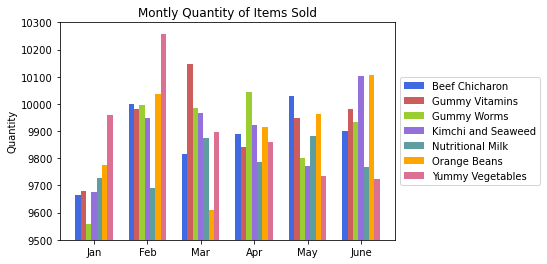

In [41]:
# BAR PLOT
n = 6
r = np.arange(n)
width = 0.10
  
plt.bar(r, chic_quant, color = 'royalblue', width = width, label='Beef Chicharon')
plt.bar(r + width, vits_quant, color = 'indianred', width = width, label='Gummy Vitamins')
plt.bar(r + 2*width, worm_quant, color = 'yellowgreen', width = width, label='Gummy Worms')
plt.bar(r + 3*width, kimc_quant, color = 'mediumpurple', width = width, label='Kimchi and Seaweed')
plt.bar(r + 4*width, milk_quant, color = 'cadetblue', width = width, label='Nutritional Milk')
plt.bar(r + 5*width, bean_quant, color = 'orange', width = width, label='Orange Beans')
plt.bar(r + 6*width, vege_quant, color = 'palevioletred', width = width, label='Yummy Vegetables')

plt.ylabel("Quantity")
plt.title("Montly Quantity of Items Sold")
plt.ylim(9500,10300)

plt.xticks(r + width + 0.2,month_labs)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
  
plt.show()

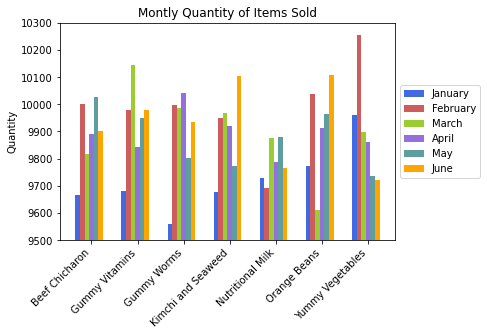

In [42]:
# BAR PLOT: items as x-axis
n = 7
r = np.arange(n)
width = 0.10
  
plt.bar(r, jan_quant, color = 'royalblue', width = width, label='January')
plt.bar(r + width, feb_quant, color = 'indianred', width = width, label='February')
plt.bar(r + 2*width, mar_quant, color = 'yellowgreen', width = width, label='March')
plt.bar(r + 3*width, apr_quant, color = 'mediumpurple', width = width, label='April')
plt.bar(r + 4*width, may_quant, color = 'cadetblue', width = width, label='May')
plt.bar(r + 5*width, jun_quant, color = 'orange', width = width, label='June')

plt.ylabel("Quantity")
plt.title("Montly Quantity of Items Sold")
plt.ylim(9500,10300)

plt.xticks(r + width+0.2,quant_labs,rotation=45, ha='right')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
  
plt.show()

In [43]:
## PART 5.2: EXTRA GRAPHS - VALUE ------------------------------------------------------------------------------------------
# according to item
chic_val = list(monthly_value.iloc[0,:])
vits_val = list(monthly_value.iloc[1,:])
worm_val = list(monthly_value.iloc[2,:])
kimc_val = list(monthly_value.iloc[3,:])
milk_val = list(monthly_value.iloc[4,:])
bean_val = list(monthly_value.iloc[5,:])
vege_val = list(monthly_value.iloc[6,:])

# according to month
jan_val = np.array(list(monthly_value.iloc[:,0]))
feb_val = np.array(list(monthly_value.iloc[:,1]))
mar_val = np.array(list(monthly_value.iloc[:,2]))
apr_val = np.array(list(monthly_value.iloc[:,3]))
may_val = np.array(list(monthly_value.iloc[:,4]))
jun_val = np.array(list(monthly_value.iloc[:,5]))

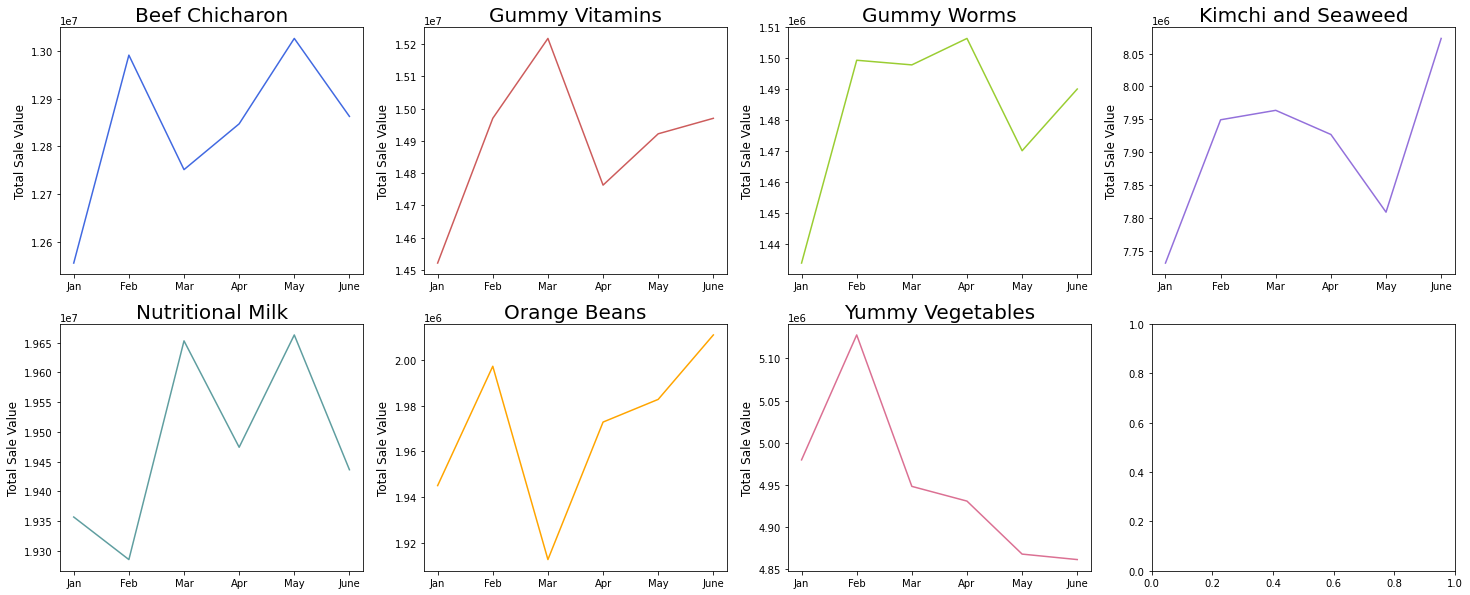

<Figure size 792x432 with 0 Axes>

In [44]:
# LINE GRAPH: behavior of total sale value sold across six months
fig, ax = plt.subplots(2,4) 
plt.figure(figsize=(11,6))
fig.set_size_inches(25,10)

ax[0,0].plot(month_labs,chic_val,color='royalblue')
ax[0,0].set_ylabel('Total Sale Value',fontsize=12)
ax[0,0].set_title('Beef Chicharon', fontsize=20)

ax[0,1].plot(month_labs,vits_val,color='indianred')
ax[0,1].set_ylabel('Total Sale Value',fontsize=12)
ax[0,1].set_title('Gummy Vitamins', fontsize=20)

ax[0,2].plot(month_labs,worm_val,color='yellowgreen')
ax[0,2].set_ylabel('Total Sale Value',fontsize=12)
ax[0,2].set_title('Gummy Worms', fontsize=20)

ax[0,3].plot(month_labs,kimc_val,color='mediumpurple')
ax[0,3].set_ylabel('Total Sale Value',fontsize=12)
ax[0,3].set_title('Kimchi and Seaweed', fontsize=20)

ax[1,0].plot(month_labs,milk_val,color='cadetblue')
ax[1,0].set_ylabel('Total Sale Value',fontsize=12)
ax[1,0].set_title('Nutritional Milk', fontsize=20)

ax[1,1].plot(month_labs,bean_val,color='orange')
ax[1,1].set_ylabel('Total Sale Value',fontsize=12)
ax[1,1].set_title('Orange Beans', fontsize=20)

ax[1,2].plot(month_labs,vege_val,color='palevioletred')
ax[1,2].set_ylabel('Total Sale Value',fontsize=12)
ax[1,2].set_title('Yummy Vegetables', fontsize=20)

plt.show()

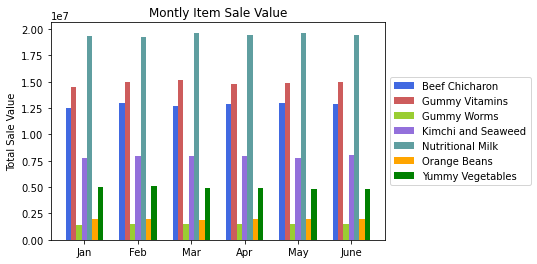

In [45]:
# BAR PLOT: months as x-axis
n = 6
r = np.arange(n)
width = 0.10
  
plt.bar(r, chic_val, color = 'royalblue', width = width, label='Beef Chicharon')
plt.bar(r + width, vits_val, color = 'indianred', width = width, label='Gummy Vitamins')
plt.bar(r + 2*width, worm_val, color = 'yellowgreen', width = width, label='Gummy Worms')
plt.bar(r + 3*width, kimc_val, color = 'mediumpurple', width = width, label='Kimchi and Seaweed')
plt.bar(r + 4*width, milk_val, color = 'cadetblue', width = width, label='Nutritional Milk')
plt.bar(r + 5*width, bean_val, color = 'orange', width = width, label='Orange Beans')
plt.bar(r + 6*width, vege_val, color = 'green', width = width, label='Yummy Vegetables')

plt.ylabel("Total Sale Value")
plt.title("Montly Item Sale Value")

plt.xticks(r + width+0.2,month_labs)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
  
plt.show()

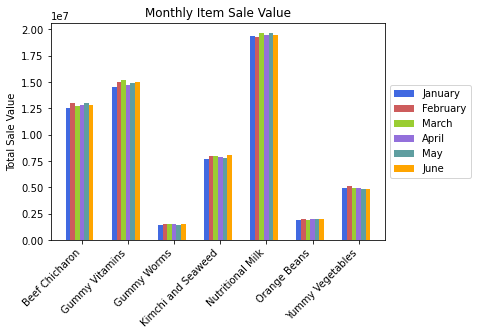

In [46]:
# BAR PLOT: items as x-axis
n = 7
r = np.arange(n)
width = 0.10
  
plt.bar(r, jan_val, color = 'royalblue', width = width, label='January')
plt.bar(r + width, feb_val, color = 'indianred', width = width, label='February')
plt.bar(r + 2*width, mar_val, color = 'yellowgreen', width = width, label='March')
plt.bar(r + 3*width, apr_val, color = 'mediumpurple', width = width, label='April')
plt.bar(r + 4*width, may_val, color = 'cadetblue', width = width, label='May')
plt.bar(r + 5*width, jun_val, color = 'orange', width = width, label='June')

plt.ylabel("Total Sale Value")
plt.title("Monthly Item Sale Value")

plt.xticks(r + width+0.2,quant_labs,rotation=45, ha='right')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
  
plt.show()

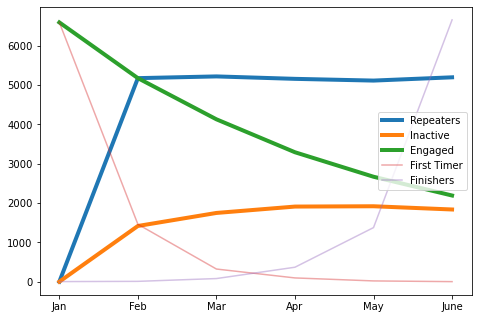

In [82]:
## PART 5.3: EXTRA GRAPHS - CUSTOMERS --------------------------------------------------------------------------------------
repeater_g = list(df2.iloc[0,:])
inactive_g = list(df2.iloc[1,:])
engaged_g = list(df2.iloc[2,:])
first_g = list(df2.iloc[3,:])
last_g = list(df2.iloc[4,:])

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

ax.plot(month_labs, repeater_g, label='Repeaters', linewidth=4)
ax.plot(month_labs, inactive_g, label='Inactive', linewidth=4)
ax.plot(month_labs, engaged_g, label='Engaged', linewidth=4)
ax.plot(month_labs, first_g, label='First Timer', alpha=0.4)
ax.plot(month_labs, last_g, label='Finishers', alpha=0.4)
ax.legend()